In [1]:
import os

output_models_path = os.environ["DATA"] + "/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/"
output_figures_path = os.environ["FIGURES"] + "/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/"


pop_size = 1000
k_to_replace = 10
max_steps = 800
record_history = False

entropy_weights = [0.1, 1, 10, 100, 1000, 0]
entropy_functions = ["entropy_ifg", "entropy_gen_scaffolds", "entropy_checkmol", "entropy_shg_1"]


In [2]:
from itertools import product

def model_id_to_model_params(model_id):
    
    exp_id = model_id // 10
    run_id = model_id % 10
    
    all_exp_param_tuples = list(product(entropy_weights, entropy_functions))
    
    entropy_function = all_exp_param_tuples[exp_id][1]
    entropy_weight = all_exp_param_tuples[exp_id][0]
    
    if entropy_weight == 0:
        entropy_function = "no_entropy"
    
    return entropy_weight, entropy_function, run_id


In [3]:
from os.path import join
import pandas as pd
import numpy as np
from os import makedirs

def compute_model_path(entropy_weight, entropy_function, run_id):

    # Computing model path
    model_name = "entropy_weight_" + str(entropy_weight) + "_" + str(entropy_function)
    model_path = join(output_models_path, model_name, str(run_id))
    return model_path


def normalizer_x_ticks(convergence, calls, max_calls=10000000):
    
    geomspace = np.geomspace(1, 10000000, 1000)
    new_calls = geomspace[geomspace <= np.max(calls)]

    new_convergence = np.interp(new_calls, calls, convergence)

    return new_convergence, new_calls
    

In [4]:
def extract_convergence_vs_calls(steps_path, convergence_key, curr_batch_max_calls=None):
    
    with open(steps_path, "r") as f:
        steps_dict = pd.read_csv(f)
        
        convergence = np.array(steps_dict["qed_"+convergence_key])
        calls = np.array(steps_dict["objective_calls"])
        
        # Adding a final point of the last QED value at the maximum call numbers encoutered during the batch of 10 experiments 
        if curr_batch_max_calls is not None and max(calls) < curr_batch_max_calls:
            convergence = np.concatenate([convergence, np.array([convergence[-1]])])
            calls = np.concatenate([calls, [curr_batch_max_calls]])
            
    return convergence, calls
        
        
def extract_all_data(convergence_key, normalize_x_ticks=False):
    
    d = {
        "run_id": np.array([]),
        "entropy_weight": np.array([]),
        "entropy": np.array([]),
        convergence_key + " qed": np.array([]),
        "# calls": np.array([])
    }
    
    for i in range(210):
        
           
        # Finding max number of calls for the batch of experiments
        if i%10 == 0:
            curr_batch_max_calls = 0
            for j in range(i, i+10):
                
                entropy_weight, entropy_function, run_id = model_id_to_model_params(j)
                model_path = compute_model_path(entropy_weight, entropy_function, run_id)
                convergence, calls = extract_convergence_vs_calls(join(model_path, "steps.csv"), convergence_key)
                curr_batch_max_calls = max(curr_batch_max_calls, max(calls))
           
        entropy_weight, entropy_function, run_id = model_id_to_model_params(i)
        model_path = compute_model_path(entropy_weight, entropy_function, run_id)
        
        convergence, calls = extract_convergence_vs_calls(join(model_path, "steps.csv"), convergence_key, curr_batch_max_calls)
        
        if normalize_x_ticks:
            convergence, calls = normalizer_x_ticks(convergence, calls)
                    
        run_id = np.full(convergence.shape, run_id)
        entropy_weight = np.full(convergence.shape, entropy_weight)
        entropy = np.full(convergence.shape, entropy_function)
        

        d["run_id"] = np.concatenate([d["run_id"], run_id])
        d["entropy_weight"] = np.concatenate([d["entropy_weight"], entropy_weight])
        d["entropy"] = np.concatenate([d["entropy"], entropy])
        d[convergence_key + " qed"] = np.concatenate([d[convergence_key + " qed"], convergence])
        d["# calls"] = np.concatenate([d["# calls"], calls])
        
    return pd.DataFrame.from_dict(d)


In [5]:
import seaborn as sns
sns.set(style="ticks", palette="colorblind", color_codes=True)
import matplotlib.pyplot as plt

def plot_score_vs_calls_1desc(convergence_key, desc, normalize_x_ticks=False):
    
    if desc == "entropy_ifg":
        ent_type = "IFG"
    elif desc == "entropy_gen_scaffolds":
        ent_type = "generic scaffolds"
    elif desc == "entropy_shg_1":
        ent_type = "lvl. 1 shingles"
    elif desc == "entropy_checkmol":
        ent_type = "checkmol"
    
    makedirs(output_figures_path, exist_ok=True)
    
    d = extract_all_data(convergence_key, normalize_x_ticks=normalize_x_ticks)
    
    d["entropy_weight"] = d["entropy_weight"].astype(str)
    d = d[np.logical_or(d["entropy"] == desc, d["entropy"] == "no_entropy")]
        
    plt.figure(figsize=(3/2*8, 8))

    p = sns.lineplot(
        data=d,
        x="# calls", y=convergence_key + " qed",
        hue="entropy_weight", style="entropy", legend="full", palette=sns.color_palette("colorblind")[:6]
    )
    
    plt.legend(title="Entropy weight (" + ent_type + ")", 
               labels=p.get_legend_handles_labels()[-1][1:7])._legend_box.align = "left"
    
    plt.xscale("log")    
    p.set(xlim=(1,3000000))
    p.set(ylim=(0, 1))
    p.set(xlabel="Number of calls", ylabel="Best QED")
    
    
    if normalize_x_ticks:
        filename = "line" + "_" + desc + "_convergence_regular_ticks" + convergence_key + ".png"
    else:
        filename = "line" + "_" + desc +"_convergence_" + convergence_key + ".png"

    plt.tight_layout()
    plt.savefig(join(output_figures_path, filename), dpi=300)


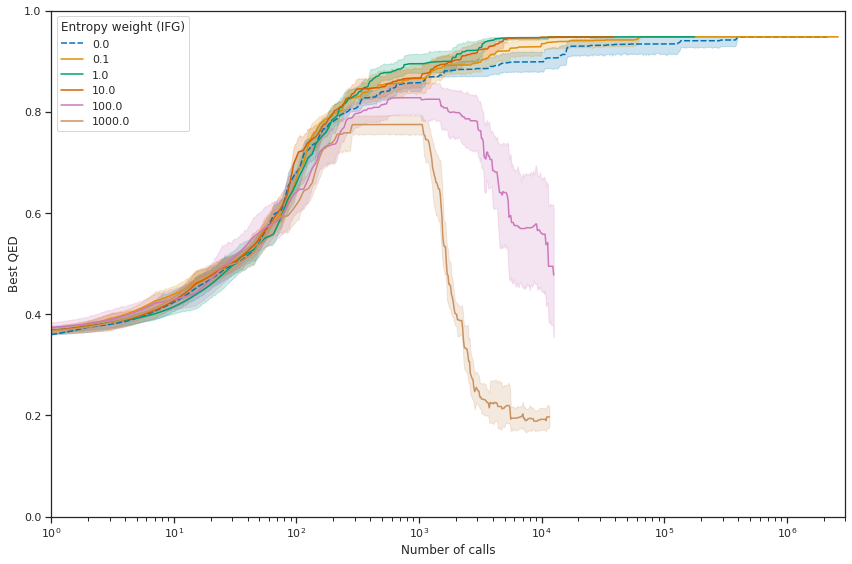

In [6]:
plot_score_vs_calls_1desc("max", "entropy_ifg", True)

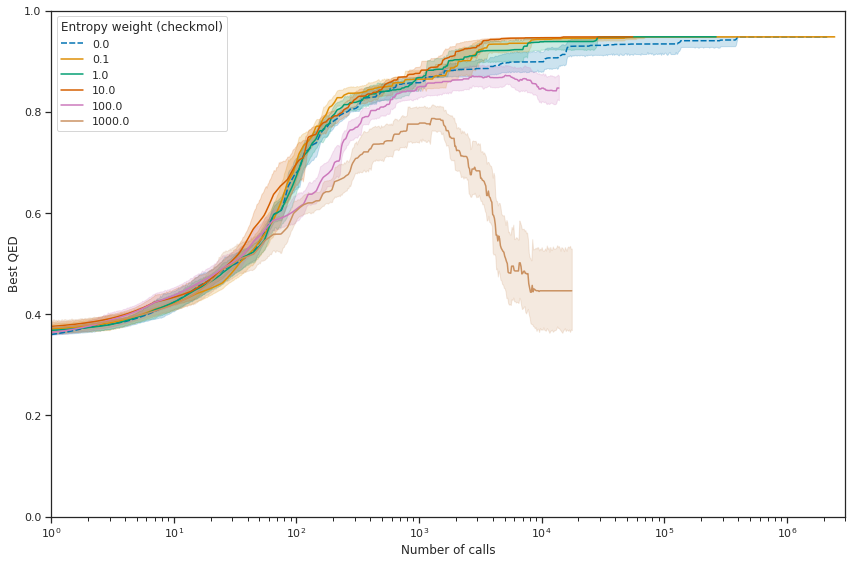

In [13]:
plot_score_vs_calls_1desc("max", "entropy_checkmol", True)

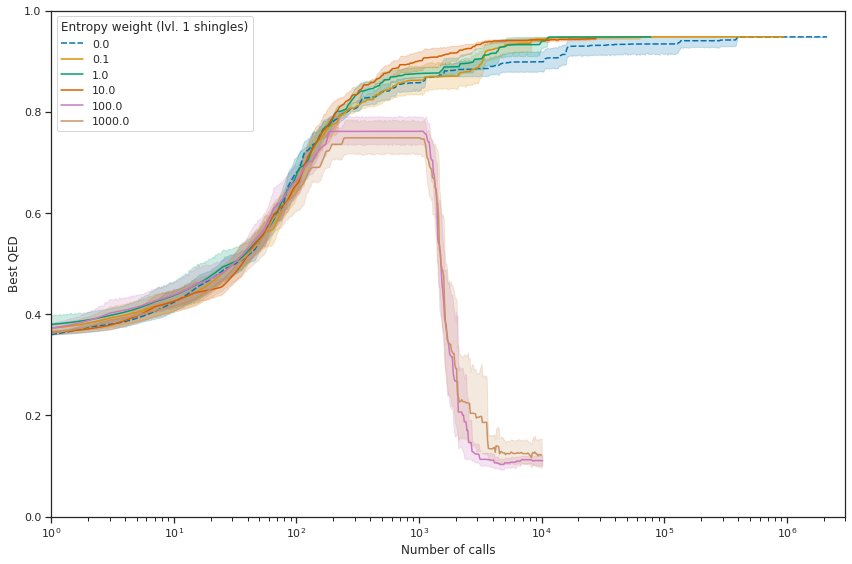

In [14]:
plot_score_vs_calls_1desc("max", "entropy_shg_1", True)

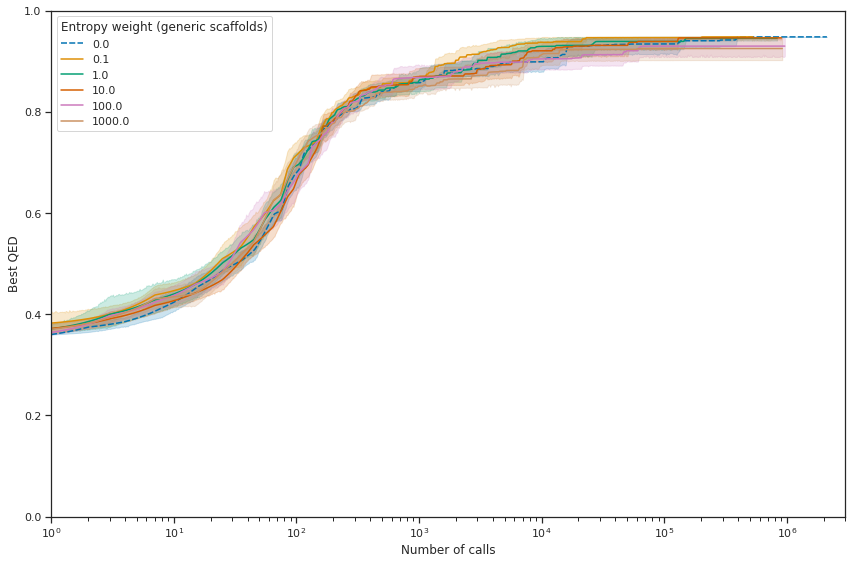

In [15]:
plot_score_vs_calls_1desc("max", "entropy_gen_scaffolds", True)